*Some contents of this notebook is from the [Python Data Science Handbook](http://shop.oreilly.com/product/0636920034919.do) by Jake VanderPlas*

# K-Means Clustering

Clustering algorithms seek to learn, from the properties of the data, an optimal division or discrete labeling of groups of points.

Many clustering algorithms are available in Scikit-Learn and elsewhere, but perhaps the simplest to understand is an algorithm known as *k-means clustering*, which is implemented in ``sklearn.cluster.KMeans``.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
import numpy as np

## Understanding k-Means

The *k*-means algorithm searches for a pre-determined number of clusters within an unlabeled multidimensional dataset.
It accomplishes this using a simple conception of what the optimal clustering looks like:

- The "cluster center" is the arithmetic mean of all the points belonging to the cluster.
- Each point is closer to its own cluster center than to other cluster centers.

Those two assumptions are the basis of the *k*-means model.
We will soon dive into exactly *how* the algorithm reaches this solution, but for now let's take a look at a simple dataset and see the *k*-means result.

First, let's generate a two-dimensional dataset containing four distinct blobs.
To emphasize that this is an unsupervised algorithm, we will leave the labels out of the visualization

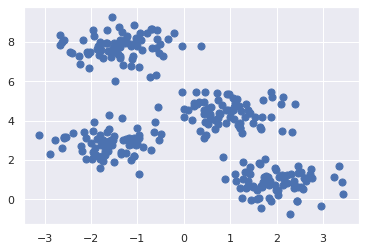

In [4]:
from sklearn.datasets.samples_generator import make_blobs
X, y_true = make_blobs(n_samples=300, centers=4,
                       cluster_std=0.60, random_state=0)
plt.scatter(X[:, 0], X[:, 1], s=50);

In [5]:
X[:5]

array([[ 0.83685684,  2.13635938],
       [-1.4136581 ,  7.40962324],
       [ 1.15521298,  5.09961887],
       [-1.01861632,  7.81491465],
       [ 1.27135141,  1.89254207]])

Scalling the features

In [6]:
from sklearn.preprocessing import StandardScaler

In [7]:
data_scaler = StandardScaler()
X = data_scaler.fit_transform(X)
X[:5]

array([[ 0.51625508, -0.70722723],
       [-0.86166376,  1.3290677 ],
       [ 0.71117444,  0.43704896],
       [-0.61979222,  1.48557283],
       [ 0.78228231, -0.8013784 ]])

By eye, it is relatively easy to pick out the four clusters.
The *k*-means algorithm does this automatically, and in Scikit-Learn uses the typical estimator API:

In [9]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4)
kmeans.fit(X)

y_kmeans = kmeans.predict(X)

In [10]:
# The lowest Sum Squared Error (SSE) value
print(kmeans.inertia_)

# The number of iterations required to converge
kmeans.n_iter_

56.02477057509952


3

Let's visualize the results by plotting the data colored by these labels.
We will also plot the cluster centers as determined by the *k*-means estimator:

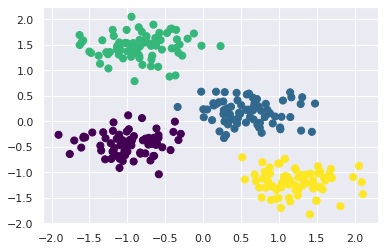

In [11]:
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')

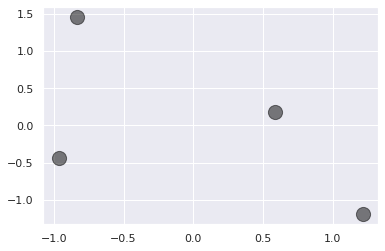

In [12]:
# plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

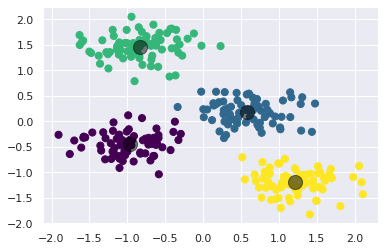

In [13]:
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

## k-Means Algorithm: Expectation–Maximization

Expectation–Maximization (E–M) is a powerful algorithm that comes up in a variety of contexts within data science.
*k*-means is a particularly simple and easy-to-understand application of the algorithm, and we will walk through it briefly here.
In short, the expectation–maximization approach here consists of the following procedure:

1. Guess some cluster centers
2. Repeat until converged
   1. *E-Step*: assign points to the nearest cluster center
   2. *M-Step*: set the cluster centers to the mean 

Here the "E-step" or "Expectation step" is so-named because it involves updating our expectation of which cluster each point belongs to.
The "M-step" or "Maximization step" is so-named because it involves maximizing some fitness function that defines the location of the cluster centers—in this case, that maximization is accomplished by taking a simple mean of the data in each cluster.

The literature about this algorithm is vast, but can be summarized as follows: under typical circumstances, each repetition of the E-step and M-step will always result in a better estimate of the cluster characteristics.

We can visualize the algorithm as shown in the following figure.
For the particular initialization shown here, the clusters converge in just three iterations.
For an interactive version of this figure, refer to the code in [the Appendix](06.00-Figure-Code.ipynb#Interactive-K-Means).

![(run code in Appendix to generate image)](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/figures/05.11-expectation-maximization.png?raw=1)
[figure source in Appendix](06.00-Figure-Code.ipynb#Expectation-Maximization)

The *k*-Means algorithm is simple enough that we can write it in a few lines of code.
The following is a very basic implementation:

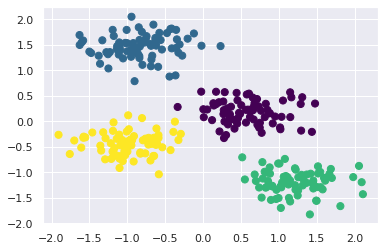

In [14]:
from sklearn.metrics import pairwise_distances_argmin

def find_clusters(X, n_clusters, rseed=2):
    # 1. Randomly choose clusters
    rng = np.random.RandomState(rseed)
    i = rng.permutation(X.shape[0])[:n_clusters]
    centers = X[i]
    
    while True:
        # 2a. Assign labels based on closest center
        labels = pairwise_distances_argmin(X, centers)
        
        # 2b. Find new centers from means of points
        new_centers = np.array([X[labels == i].mean(0)
                                for i in range(n_clusters)])
        
        # 2c. Check for convergence
        if np.all(centers == new_centers):
            break
        centers = new_centers
    
    return centers, labels

centers, labels = find_clusters(X, 4)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

### Caveats of expectation–maximization

There are a few drawbacks to be aware of k-means algorithm.

#### The globally optimal result may not be achieved
First, although the E–M procedure is guaranteed to improve the result in each step, there is no assurance that it will lead to the *global* best solution.
For example, if we use a different random seed in our simple procedure, the particular starting guesses lead to poor results:

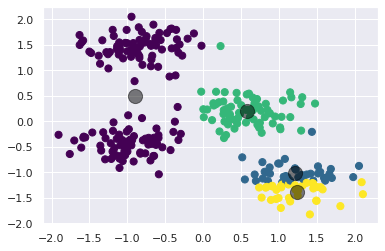

In [17]:
centers, labels = find_clusters(X, 4, rseed=0)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis');
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

Here the E–M approach has converged, but has not converged to a globally optimal configuration. For this reason, it is common for the algorithm to be run for multiple starting guesses, as indeed Scikit-Learn does by default (set by the ``n_init`` parameter, which defaults to 10).

#### The number of clusters must be selected beforehand
Another common challenge with *k*-means is that you must tell it how many clusters you expect: it cannot learn the number of clusters from the data.
For example, if we ask the algorithm to identify six clusters, it will happily proceed and find the best six clusters:

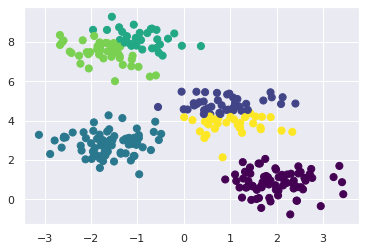

In [16]:
labels = KMeans(6, random_state=0).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

#### Choosing the Appropriate Number of Clusters
In this section, you’ll look at two methods that are commonly used to evaluate the appropriate number of clusters:

* The elbow method
* The silhouette coefficient

These are often used as complementary evaluation techniques rather than one being preferred over the other. To perform the elbow method, run several k-means, increment k with each iteration, and record the SSE:

**Elbow method**

In [20]:
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 30,
    "random_state": 42,
}
   
# A list holds the SSE values for each k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(X)
    sse.append(kmeans.inertia_)

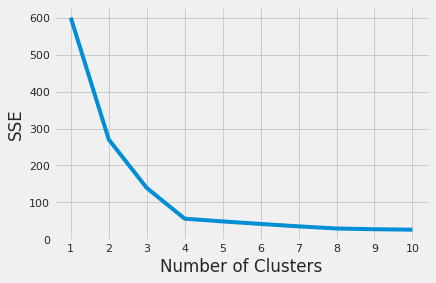

In [21]:
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

##### Silhouette Coefficient
The silhouette coefficient is a measure of cluster cohesion and separation. It quantifies how well a data point fits into its assigned cluster based on two factors:

* How close the data point is to other points in the cluster
* How far away the data point is from points in other clusters

Silhouette coefficient values range between -1 and 1. Larger numbers indicate that samples are closer to their clusters than they are to other clusters.

In [18]:
from sklearn.metrics import silhouette_score

In [21]:
# A list holds the silhouette coefficients for each k
silhouette_coefficients = []

# Notice you start at 2 clusters for silhouette coefficient
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(X)
    score = silhouette_score(X, kmeans.labels_)
    silhouette_coefficients.append(score)

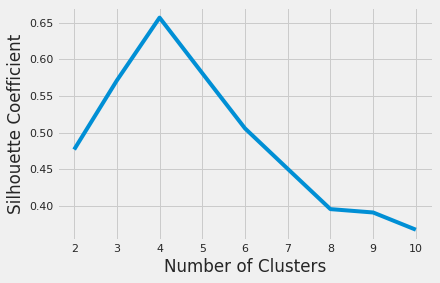

In [22]:
plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

#### k-means is limited to linear cluster boundaries
The fundamental model assumptions of *k*-means (points will be closer to their own cluster center than to others) means that the algorithm will often be ineffective if the clusters have complicated geometries.

In particular, the boundaries between *k*-means clusters will always be linear, which means that it will fail for more complicated boundaries.
Consider the following data, along with the cluster labels found by the typical *k*-means approach:

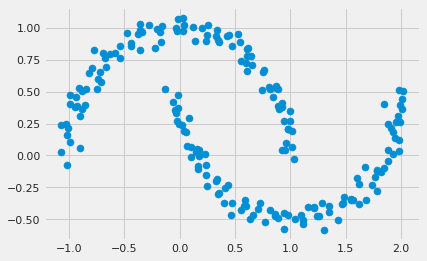

In [23]:
from sklearn.datasets import make_moons
X, y = make_moons(200, noise=.05, random_state=0)
plt.scatter(X[:, 0], X[:, 1], s=50);

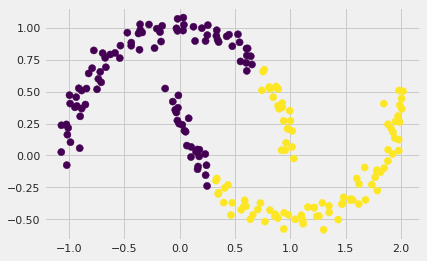

In [24]:
labels = KMeans(2, random_state=0).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

#### Density-Based Spatial Clustering of Applications with Noise (DBSCAN)
DBSCAN works based on the idea that a cluster in data space is a contiguous region of high point density, separated from other such clusters by contiguous regions of low point density.

The DBSCAN algorithm uses two parameters:

* min_samples: The minimum number of points (a threshold) clustered together for a region to be considered dense.
* eps (ε): A distance measure that will be used to locate the points in the neighborhood of any point.

In [25]:
from sklearn.cluster import DBSCAN

kmeans = KMeans(n_clusters=2)
dbscan = DBSCAN(eps=0.3, min_samples=3)

kmeans.fit(X)
dbscan.fit(X)

# Compute the silhouette scores for each algorithm
kmeans_silhouette = silhouette_score(
    X, kmeans.labels_
).round(2)

dbscan_silhouette = silhouette_score(
   X, dbscan.labels_
).round(2)

print(kmeans_silhouette, dbscan_silhouette)

0.49 0.33


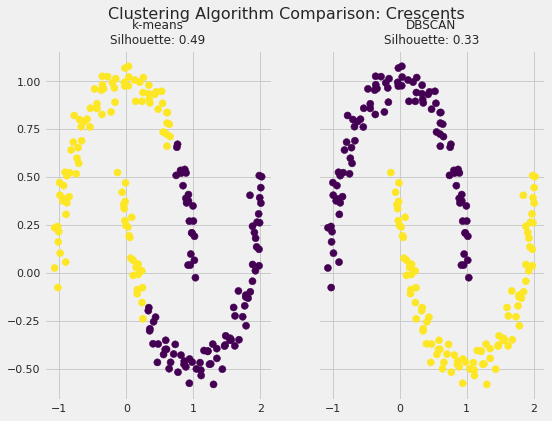

In [26]:
# Plot the data and cluster silhouette comparison
fig, (ax1, ax2) = plt.subplots(
    1, 2, figsize=(8, 6), sharex=True, sharey=True
)
fig.suptitle(f"Clustering Algorithm Comparison: Crescents", fontsize=16)
fte_colors = {
    0: "#008fd5",
    1: "#fc4f30",
}
# The k-means plot
# km_colors = [fte_colors[label] for label in kmeans.labels_]
ax1.scatter(X[:, 0], X[:, 1], c=kmeans.labels_, s=50, cmap='viridis')
ax1.set_title(
    f"k-means\nSilhouette: {kmeans_silhouette}", fontdict={"fontsize": 12}
)

# The dbscan plot, 
# db_colors = [fte_colors[label] for label in dbscan.labels_]
ax2.scatter(X[:, 0], X[:, 1], c=dbscan.labels_, s=50, cmap='viridis')
ax2.set_title(
    f"DBSCAN\nSilhouette: {dbscan_silhouette}", fontdict={"fontsize": 12}
)
plt.show()

##### Evaluating Clusters
Since the ground truth labels are known, it’s possible to use a clustering metric that considers labels in its evaluation. You can use the scikit-learn implementation of a common metric called the adjusted rand index (ARI). Unlike the silhouette coefficient, the ARI uses true cluster assignments to measure the similarity between true and predicted labels.

In [46]:
from sklearn.metrics import adjusted_rand_score

In [48]:
ari_kmeans = adjusted_rand_score(y, kmeans.labels_)
ari_dbscan = adjusted_rand_score(y, dbscan.labels_)
print(ari_kmeans, ari_dbscan)

0.25636350688711773 1.0


#### k-means can be slow for large numbers of samples
Because each iteration of *k*-means must access every point in the dataset, the algorithm can be relatively slow as the number of samples grows.

## Example

Being careful about these limitations of the algorithm, we can use *k*-means to our advantage in a wide variety of situations.
We'll now take a look at a couple examples.

### Example: k-means on digits

To start, let's take a look at applying *k*-means on the same simple digits data.
Here we will attempt to use *k*-means to try to identify similar digits *without using the original label information*.

We will start by loading the digits and then finding the ``KMeans`` clusters.
"digits" dataset consist of 1,797 samples with 64 features, where each of the 64 features is the brightness of one pixel in an 8×8 image:

In [28]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

The clustering can be performed as we did before:

In [29]:
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(digits.data)
print(kmeans.cluster_centers_.shape)
kmeans.cluster_centers_[0]

(10, 64)


array([ 0.00000000e+00, -9.99200722e-16,  3.07228916e-01,  7.16265060e+00,
        1.19457831e+01,  1.93373494e+00,  1.50602410e-01,  5.42168675e-02,
       -2.25514052e-17,  1.20481928e-02,  3.28313253e+00,  1.37951807e+01,
        8.46385542e+00,  1.53012048e+00,  9.75903614e-01,  2.77108434e-01,
       -1.12757026e-17,  6.44578313e-01,  1.07108434e+01,  1.15602410e+01,
        4.33734940e+00,  5.25903614e+00,  3.87349398e+00,  3.25301205e-01,
        6.02409639e-03,  4.75903614e+00,  1.47590361e+01,  5.86144578e+00,
        6.87951807e+00,  1.07530120e+01,  6.21686747e+00,  1.80722892e-02,
        0.00000000e+00,  8.92771084e+00,  1.48072289e+01,  9.35542169e+00,
        1.28132530e+01,  1.43915663e+01,  5.48192771e+00,  0.00000000e+00,
        9.63855422e-02,  6.50602410e+00,  1.16867470e+01,  1.23433735e+01,
        1.48373494e+01,  1.07590361e+01,  1.56626506e+00, -4.16333634e-17,
        6.02409639e-02,  1.11445783e+00,  3.00000000e+00,  7.77710843e+00,
        1.40843373e+01,  

The result is 10 clusters in 64 dimensions.
Notice that the cluster centers themselves are 64-dimensional points, and can themselves be interpreted as the "typical" digit within the cluster.
Let's see what these cluster centers look like:

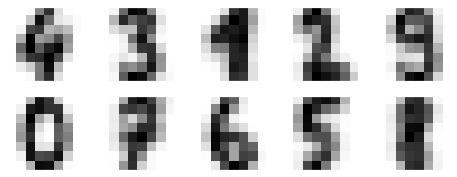

In [22]:
fig, ax = plt.subplots(2, 5, figsize=(8, 3))
centers = kmeans.cluster_centers_.reshape(10, 8, 8)
for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

We see that *even without the labels*, ``KMeans`` is able to find clusters whose centers are recognizable digits, with perhaps the exception of 1 and 8.

Because *k*-means knows nothing about the identity of the cluster, the 0–9 labels may be permuted.
We can fix this by matching each learned cluster label with the true labels found in them:

In [30]:
from scipy.stats import mode

labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]

Now we can check how accurate our unsupervised clustering was in finding similar digits within the data:

In [31]:
from sklearn.metrics import accuracy_score
accuracy_score(digits.target, labels)

0.7952142459654981

With just a simple *k*-means algorithm, we discovered the correct grouping for 80% of the input digits!
Let's check the confusion matrix for this:

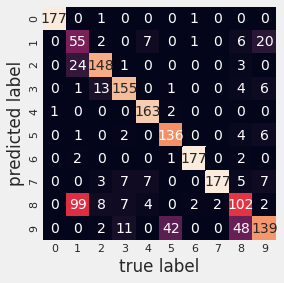

In [32]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(digits.target, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=digits.target_names,
            yticklabels=digits.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

As we might expect from the cluster centers we visualized before, the main point of confusion is between the eights and ones.
But this still shows that using *k*-means, we can essentially build a digit classifier *without reference to any known labels*!

t-SNE is a nonlinear embedding algorithm that is particularly adept at preserving points within clusters.
Let's see how it does:

In [26]:
from sklearn.manifold import TSNE

# Project the data: this step will take several seconds
tsne = TSNE(n_components=2, init='random', random_state=0)
digits_proj = tsne.fit_transform(digits.data)

# Compute the clusters
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(digits_proj)

# Permute the labels
labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]

# Compute the accuracy
accuracy_score(digits.target, labels)

0.9371174179187535

That's nearly 93+% classification accuracy *without using the labels*.